In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [3]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [4]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/2020-general-election-rev/")

In [5]:
#Minor processing note: For the FRA file, I replaced ""AJ"" w/ "AJ", so the load works

In [6]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store":
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

In [7]:
li = []
for i in all_files:
    if i not in [".DS_Store","DAD_PctResults20201103recount.txt","BRO_PctResults20201103recount.txt"]:
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(553307, 19)


In [8]:
#Filter to the presidential results
frame =frame[frame[11]=='President of the United States']

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame[14].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame[6] = filtered_frame[6].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row[6].split("PRECINCT ")[1])) if row[0]=="DAD" else row[5], axis=1)

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["Pct_std"]=filtered_frame[0]+filtered_frame["modified_pre"]

<ipython-input-8-9f84ba61cc32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame[6] = filtered_frame[6].astype(str)
<ipython-input-8-9f84ba61cc32>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row[6].split("PRECINCT ")[1])) if row[0]=="DAD" else row[5], axis=1)
<ipython-input-8-9f84ba61cc32>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [9]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=[18], index=["Pct_std"],columns=[11,14],aggfunc=sum)

#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

#Rename the columns
pivoted_2020.columns = ["pct_std","G20PREDBID","G20PRECBLA","G20PREODEL","G20PREGHAW","G20PRELJOR","G20PRESLAR","G20PRERTRU","G20PREOWRI"]

## Check Statewide Totals

In [10]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [11]:
statewide_totals_check(vest_fl_20,pivoted_2020,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 15 votes
	VEST: 5668731 votes
	SOURCES: 5668716 votes
G20PREDBID has a difference of 9 votes
	VEST: 5297045 votes
	SOURCES: 5297036 votes
G20PRELJOR has a difference of 1 votes
	VEST: 70324 votes
	SOURCES: 70323 votes
G20PREODEL is equal 	VEST / RDH: 5966
G20PRESLAR is equal 	VEST / RDH: 5712
G20PREGHAW is equal 	VEST / RDH: 14721
G20PRECBLA is equal 	VEST / RDH: 3902
G20PREOWRI is equal 	VEST / RDH: 24468


## Check County-by-County Totals

In [12]:
#Add a county column
pivoted_2020["county"] = pivoted_2020["pct_std"].str[0:3]

In [13]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [14]:
county_totals_check(vest_fl_20,pivoted_2020,data_columns,"county",full_print=False)

#Used the below to check against the official state totals
#vest_fl_20.groupby(["county"]).sum().to_csv("./vest_county_totals.csv")

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	MON has a difference of 10 votes
		VEST: 25693 votes
		SOURCES: 25683 votes
	SEM has a difference of 5 votes
		VEST: 125241 votes
		SOURCES: 125236 votes
G20PREDBID contains differences in these counties:
	MON has a difference of 5 votes
		VEST: 21881 votes
		SOURCES: 21876 votes
	SEM has a difference of 4 votes
		VEST: 132528 votes
		SOURCES: 132524 votes
G20PRELJOR contains differences in these counties:
	MON has a difference of 1 votes
		VEST: 348 votes
		SOURCES: 347 votes
G20PREODEL is equal across all counties
G20PRESLAR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOWRI is equal across all counties


### Precinct-by-Precinct Check

In [15]:
#Check if the columns are unique
vest_fl_20["pct_std"].value_counts(dropna=False)
pivoted_2020["pct_std"].value_counts(dropna=False)

DAD0257    1
PIN0630    1
HIG0024    1
DAD0142    1
PAS0090    1
          ..
DUV0403    1
PAL4078    1
HIL0521    1
ORA0622    1
LAK0043    1
Name: pct_std, Length: 6014, dtype: int64

In [16]:
#Combine results in these two precincts to match VEST
for i in data_columns:
    pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.0",i]+=int(pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.1",i])

#Check that it works
pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.0"]

#Remove the precinct that the votes were added from
pivoted_2020 = pivoted_2020[pivoted_2020["pct_std"]!="CHA54.1"]

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

In [17]:
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0900',
 'SEM0901',
 'SEM0902',
 'SEM0903',
 'SEM0904',
 'SEM0905',
 'SEM0906',
 'SEM0907',
 'SEM0908',
 'SEM0909',
 'SEM0910',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512']

In [18]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [19]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [20]:
#Perform the allocation
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,data_columns,"county",allocating_to_all_empty_precs=False)

In [21]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_one["_merge"].value_counts()

both          5918
left_only       92
right_only      72
Name: _merge, dtype: int64

In [22]:
# election_vest_id_changes = pd.read_csv("./election_vest_id_changes.csv")
# election_vest_id_changes_dict = dict(zip(election_vest_id_changes["election_ID"],election_vest_id_changes["vest_ID"]))

In [23]:
#Make changes to increase joins
election_vest_id_changes_dict = {'UNI1A & 1B': 'UNI001A', 'UNI2A & 2B': 'UNI002A', 'UNI3A & 3B': 'UNI003A', 'UNI4A & 4C': 'UNI004A', 'UNI5A & 5C': 'UNI005A', 'CHA01.0': 'CHA0001', 'CHA02.0': 'CHA0002', 'CHA03.0': 'CHA0003', 'CHA04.0': 'CHA0004', 'CHA05.0': 'CHA0005', 'CHA06.0': 'CHA0006', 'CHA07.0': 'CHA0007', 'CHA08.0': 'CHA0008', 'CHA09.0': 'CHA0009', 'CHA10.0': 'CHA0010', 'CHA11.0': 'CHA0011', 'CHA12.0': 'CHA0012', 'CHA13.0': 'CHA0013', 'CHA14.0': 'CHA0014', 'CHA15.0': 'CHA0015', 'CHA16.0': 'CHA0016', 'CHA17.0': 'CHA0017', 'CHA18.0': 'CHA0018', 'CHA19.0': 'CHA0019', 'CHA20.0': 'CHA0020', 'CHA21.0': 'CHA0021', 'CHA22.0': 'CHA0022', 'CHA23.0': 'CHA0023', 'CHA24.0': 'CHA0024', 'CHA25.0': 'CHA0025', 'CHA26.0': 'CHA0026', 'CHA27.0': 'CHA0027', 'CHA28.0': 'CHA0028', 'CHA29.0': 'CHA0029', 'CHA30.0': 'CHA0030', 'CHA31.0': 'CHA0031', 'CHA32.0': 'CHA0032', 'CHA33.0': 'CHA0033', 'CHA34.0': 'CHA0034', 'CHA35.0': 'CHA0035', 'CHA36.0': 'CHA0036', 'CHA38.0': 'CHA0038', 'CHA39.0': 'CHA0039', 'CHA41.0': 'CHA0041', 'CHA42.0': 'CHA0042', 'CHA43.0': 'CHA0043', 'CHA44.0': 'CHA0044', 'CHA45.0': 'CHA0045', 'CHA46.0': 'CHA0046', 'CHA47.0': 'CHA0047', 'CHA48.0': 'CHA0048', 'CHA49.0': 'CHA0049', 'CHA52.0': 'CHA0052', 'CHA53.0': 'CHA0053', 'CHA55.0': 'CHA0055', 'CHA56.0': 'CHA0056', 'CHA57.0': 'CHA0057', 'CHA58.0': 'CHA0058', 'CHA60.0': 'CHA0060', 'CHA61.0': 'CHA0061', 'CHA63.0': 'CHA0063', 'CHA64.0': 'CHA0064', 'CHA66.0': 'CHA0066', 'CHA67.0': 'CHA0067', 'CHA68.0': 'CHA0068', 'CHA69.0': 'CHA0069', 'CHA75.0': 'CHA0075', 'CHA76.0': 'CHA0076', 'CHA77.0': 'CHA0077', 'CHA78.0': 'CHA0078', 'CHA80.0': 'CHA0080', 'CHA54.0': 'CHA0054'}

#Implement the changes
pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

#Join again
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_two["_merge"].value_counts()

both          5990
left_only       20
right_only       0
Name: _merge, dtype: int64

In [24]:
#Confirm that the unjoined precincts contain 0 votes
join_attempt_two[join_attempt_two["_merge"]=="left_only"]

,pct_std,county_x,precinct,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20PREODEL_x,G20PRESLAR_x,G20PREGHAW_x,G20PRECBLA_x,G20PREOWRI_x,geometry,G20PREDBID_y,G20PRECBLA_y,G20PREODEL_y,G20PREGHAW_y,G20PRELJOR_y,G20PRESLAR_y,G20PRERTRU_y,G20PREOWRI_y,county_y,_merge
697,BROZ073,BRO,Z073,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.14398 26.12165 0.00000, -80.14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
926,FLA0998,FLA,998,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-81.37445 29.29899 0.00000, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1451,HIL0999,HIL,999,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.45425 27.94811 0.00000, -82.45...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2268,PIN0512,PIN,512,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.79992 27.96092 0.00000, -82.80...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2956,BRE0000,BRE,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-80.86140 28.25218 0.00000, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987,BRE0134,BRE,134,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.77807 28.52690 0.00000, -80.77...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3128,BRE0999,BRE,999,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.80985 28.60905 0.00000, -80.80...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3173,CLL0450,CLL,450,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.76253 26.16063 0.00000, -81.76...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3663,LEO4115,LEO,4115,0,0,0,0,0,0,0,0,"POLYGON Z ((-84.14379 30.48879 0.00000, -84.14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3667,LEO5113,LEO,5113,0,0,0,0,0,0,0,0,"POLYGON Z ((-84.14727 30.47918 0.00000, -84.14...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [25]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [26]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"pct_std",print_level=0)

G20PRERTRU .................................................................MON0005 (V) .1000  (S)..999 (D):    1
G20PREDBID .................................................................MON0005 (V) .1706  (S).1705 (D):    1
G20PRELJOR .................................................................MON0005 (V) ...35  (S)...34 (D):    1
G20PREDBID .................................................................MON0006 (V) ..927  (S)..926 (D):    1
G20PREDBID .................................................................MON0008 (V) ..931  (S)..930 (D):    1
G20PREDBID .................................................................MON0010 (V) ..959  (S)..958 (D):    1
G20PRERTRU .................................................................MON0011 (V) .1213  (S).1212 (D):    1
G20PREDBID .................................................................MON0011 (V) .1101  (S).1100 (D):    1
G20PRERTRU .................................................................MON0012 (V) 

# Shapefiles

### 1. Department of State

Quote from the documentation:

> Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  

In [27]:
ALA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ALA/ALA20121106v6_PctMap/ALA20121106v6_PctMap.shp")
BAY_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAY/BAY20120501_PctMap/CensusPrecinct_region.shp")
BRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRA/BRA20140106_PctMapaca38d35-1a03-4780-80bd-aa38a9b297c1/BRA20121106v6_PctMap/BRA20121106v5_PctMap.shp")
BRE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRE/BRE20200430_Pct1370d2e2-064d-47b4-b963-43ee7731daee/BRE_Pct.shp")
CAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CAL/CAL20121106v6_PctMap/CAL20121106v6_PctMap.shp")
CIT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CIT/CIT20200228_PctMapFile/PRECINCT2020.shp")
CLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLA/CLA20160503_PctMapcc84b5a6-3ade-4dd9-acd8-4c8157bcd343/CLA20160503_PctMap.shp")
DIX_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DIX/DIX20121106v6_PctMap/DIX20121106v6_PctMap.shp")
ESC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ESC/Precinct_Map_2018/PRECINCT_MAP_022018.shp")
HAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAR/HAR20121106v6_PctMap/HAR20121106v6_PctMap.shp")
HEN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HEN/HEN20121106v6_PctMaped1303a5-dc65-41db-ac5f-a2bc3e07721a/HEN20121106v5_PctMap.shp")
HER_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HER/HER20121106v6_PctMap/HER20121106v6_PctMap.shp")
IND_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/IND/IND20150210_PctMap/IND20150210_PctMap_region.shp")
LAF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAF/LAF20121106v6_PctMap/LAF20121106v6_PctMap.shp")
SAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAR/SAR20140109v6_PctMapf831e47b-44f3-4954-a8e8-052b3a084322/SarasotaCounty_Pcts_051613_region.shp")

In [28]:
CLA_pct=CLA_pct.dissolve(by="PRECINCT")
CLA_pct.reset_index(inplace=True)

BAY_pct=BAY_pct.dissolve(by="PCT")
BAY_pct.reset_index(inplace=True)

BRE_pct=BRE_pct.dissolve(by="Precinct")
BRE_pct.reset_index(inplace=True)

In [29]:
ALA_pct['new_county']='ALA'
BAY_pct['new_county']='BAY'
BRA_pct['new_county']='BRA'
BRE_pct['new_county']='BRE'
CAL_pct['new_county']='CAL'
CIT_pct['new_county']='CIT'
CLA_pct['new_county']='CLA'
DIX_pct['new_county']='DIX'
ESC_pct['new_county']='ESC'
HAR_pct['new_county']='HAR'
HEN_pct['new_county']='HEN'
HER_pct['new_county']='HER'
IND_pct['new_county']='IND'
LAF_pct['new_county']='LAF'
SAR_pct['new_county']='SAR'

ALA_pct=ALA_pct.to_crs(vest_fl_20.crs)
BAY_pct=BAY_pct.to_crs(vest_fl_20.crs)
BRA_pct=BRA_pct.to_crs(vest_fl_20.crs)
BRE_pct=BRE_pct.to_crs(vest_fl_20.crs)
CAL_pct=CAL_pct.to_crs(vest_fl_20.crs)
CIT_pct=CIT_pct.to_crs(vest_fl_20.crs)
CLA_pct=CLA_pct.to_crs(vest_fl_20.crs)
DIX_pct=DIX_pct.to_crs(vest_fl_20.crs)
ESC_pct=ESC_pct.to_crs(vest_fl_20.crs)
HAR_pct=HAR_pct.to_crs(vest_fl_20.crs)
HEN_pct=HEN_pct.to_crs(vest_fl_20.crs)
HER_pct=HER_pct.to_crs(vest_fl_20.crs)
IND_pct=IND_pct.to_crs(vest_fl_20.crs)
LAF_pct=LAF_pct.to_crs(vest_fl_20.crs)
SAR_pct=SAR_pct.to_crs(vest_fl_20.crs)


#### Create a list with these counties precincts

In [30]:
fl_2020_shapefiles = [ALA_pct,BAY_pct,BRA_pct,BRE_pct,CAL_pct,CIT_pct,CLA_pct,DIX_pct,ESC_pct,HAR_pct,
HEN_pct,HER_pct,IND_pct,LAF_pct,SAR_pct]

#### Clean up these precinct files

In [31]:
cleaned_fl_list = []
for i in fl_2020_shapefiles:
    i.rename(columns={"PRECINCT":"Precinct","PCT":"Precinct","DISTRICT":"Precinct",
        "PrecMay201":"Precinct","PCT2014":"Precinct",'PRECINCTID':"Precinct"},inplace=True)
    i=i[["Precinct","geometry","new_county"]]
    i.rename(columns={"new_county":"county"},inplace=True)
    cleaned_fl_list.append(i)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [32]:
for i in cleaned_fl_list:
    if (i["county"].unique()==["BRE"]):
        i.loc[:,"Precinct"] = (i.loc[:,"Precinct"].astype(float)-.1).astype(int)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [33]:
#Make a combined list of these
dos_shapefiles = pd.concat(cleaned_fl_list)

### 2. Orlando Sentinel Precinct Map

> Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).

Note: We are not able to pull down the shapefile data from this map, but we do have screenshots saved in the raw-from-source file, available on request.

### 3. Census Source

Quote from the documentation:

> Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.

In [34]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties

fips_codes = ["12003","12015","12037","12043","12059","12063","12065","12075","12077","12079","12087","12093",
        "12095","12117","12121","12123","12129","12131","12133"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/shapefiles/census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)
#print(shapefiles_census.shape)

In [35]:
#Make a dictionary to convert from FIPS identifier to the 3 character county name
county_code = {'003':'BAK','015':"CHA", '037':"FRA", '043':"GLA",'059':"HOL", '063':"JAC", '065':"JEF", 
               '075':"LEV", '077':"LIB", '079':"MAD",'087':'MON','093':"OKE", '095':"ORA",
 '117':"SEM", '121':"SUW", '123':"TAY", '129':"WAK", '131':"WAL", '133':"WAS"}

#Create a column with this 3-character county name
shapefiles_census['county_name'] = shapefiles_census['COUNTYFP'].map(county_code)

In [36]:
#Create a unique identifier, looks like "VTDST" is the best column to use for this, see above

#Work on the "NAMELSAD" column to just store this as well
shapefiles_census["NAMELSAD"]= shapefiles_census["NAMELSAD"].str.split("-", n = 1, expand = True)

#Take off the leading zero
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.lstrip('0')

#Make sure they are all at least four digits
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.zfill(4)
shapefiles_census["NAMELSAD"] = shapefiles_census["NAMELSAD"].str.zfill(4)

#Create the unique identifier
shapefiles_census["Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["VTDST"]
shapefiles_census["alt_Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["NAMELSAD"]

#Confirm that the unique identifier really is unique
print(shapefiles_census["Pct_std"].value_counts())

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_census=shapefiles_census[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_census = shapefiles_census.to_crs(vest_fl_20.crs)

WAL0540    1
MON0003    1
ORA615B    1
SEM0006    1
ORA0410    1
          ..
ORA419Z    1
TAY0014    1
ORA131C    1
ORA202C    1
SEM0031    1
Name: Pct_std, Length: 708, dtype: int64


In [37]:
shapefiles_census

,Pct_std,geometry
0,BAK001A,"POLYGON Z ((-82.39816 30.31293 0.00000, -82.39..."
1,BAK002A,"POLYGON Z ((-82.18663 30.14274 0.00000, -82.18..."
2,BAK003A,"POLYGON Z ((-82.15124 30.29989 0.00000, -82.15..."
3,BAK004A,"POLYGON Z ((-82.45953 30.58425 0.00000, -82.45..."
4,BAK004B,"POLYGON Z ((-82.45941 30.57615 0.00000, -82.45..."
...,...,...
703,WAS007A,"POLYGON Z ((-85.49459 30.59116 0.00000, -85.49..."
704,WAS009C,"POLYGON Z ((-85.57625 30.66522 0.00000, -85.57..."
705,WAS009D,"POLYGON Z ((-85.56866 30.59079 0.00000, -85.56..."
706,WAS004D,"POLYGON Z ((-85.59231 30.74742 0.00000, -85.58..."


### 4. Counties Themselves

> Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.

What I was able to find:

- DeSoto - (not found) 
- Gulf - (not found)
- Sumter  - (couldn't find)  
- Polk - (couldn't find)

- Columbia -  (only map found)   
- Duval -  (only map found)
- Highlands - (only map found)
- Lake - (only map found)
- Marion - (only map found)
- Osceola  -  (only map found)
- Volusia  -  (only map found) 

- Collier - (downloaded)    
- Flagler - (downloaded) 
- Hillsborough - (downloaded)   
- Lee - (downloaded) 
- Leon - (downloaded) 
- Martin - (downloaded)
- Miami-Dade  - (downloaded)   
- Okaloosa  - (downloaded)  
- Palm Beach  -  (downloaded)  
- Pasco  -  (downloaded) 
- Pinellas -  (downloaded)
- Putnam - (downloaded)

#### Load all the files

In [38]:
#For Collier, I had to load the KML into Google Earth Pro and then export it to get the precinct labels to show up (see report)

flagler_pcts = gp.read_file("./raw-from-source/shapefiles/counties/Flagler/2018-02-05/VTDBLK_1_region.shp")
shapefiles_hillsborough = gp.read_file("./raw-from-source/shapefiles/counties/Hillsborough/2017ShapeFiles/PRECINCT12057_region.shp")
shapefiles_leon = gp.read_file("./raw-from-source/shapefiles/counties/Leon/Election_Precincts_-_Leon_County-shp/Election_Precincts_-_Leon_County.shp")
shapefiles_miami = gp.read_file("./raw-from-source/shapefiles/counties/Miami/Miami_Precinct-shp/Precinct.shp")
shapefiles_okaloosa = gp.read_file("./raw-from-source/shapefiles/counties/Okaloosa/Voting/precinct.shp")
shapefiles_palm = gp.read_file("./raw-from-source/shapefiles/counties/Palm/Palm Beach SOE Shapefiles 2021/Precincts 2021.shp")
shapefiles_pasco = gp.read_file("./raw-from-source/shapefiles/counties/Pasco/Pasco VotingPrecincts/VotingPrecincts_12112020.shp")
shapefiles_pinellas = gp.read_file("./raw-from-source/shapefiles/counties/Pinellas/Voting_Precincts/Voting_Precincts.shp")
shapefiles_putnam = gp.read_file("./raw-from-source/shapefiles/counties/Putnam/Voting_Precincts_OD/Voting_Precincts.shp")

In [39]:
shapefiles_collier = gp.read_file("./raw-from-source/shapefiles/counties/Collier/Precinct Boundaries_collier.kml",driver='KML')
shapefiles_lee = gp.read_file("./raw-from-source/shapefiles/counties/Lee/Lee County Precincts.kml",driver='KML',split="<br>")
shapefiles_martin =gp.read_file("./raw-from-source/shapefiles/counties/Martin/Martin County Voting Precincts (Interactive Street Map) (1).kml",driver='KML')

In [40]:
vest_proj = vest_fl_20.crs

#### Martin County

In [41]:
shapefiles_martin.index += 1
shapefiles_martin["Pct_std"]="MRT"+shapefiles_martin.index.astype(str).str.zfill(4)
shapefiles_martin = shapefiles_martin[["Pct_std","geometry"]]

#### Lee County

In [42]:
shapefiles_lee["type"]=shapefiles_lee["Name"].apply(lambda x: x[0])
shapefiles_lee = shapefiles_lee[shapefiles_lee["type"]!="("]
shapefiles_lee["Pct_std"]="LEE"+shapefiles_lee['Name'].astype(str).str.zfill(4)

#### Collier County

In [43]:
shapefiles_collier["Pct_std"]="CLL"+shapefiles_collier["Name"].str[9:12].str.zfill(4)
shapefiles_collier = shapefiles_collier[["Pct_std","geometry"]]

#### Putnam County

In [44]:
shapefiles_putnam["PRECINCTID"] = shapefiles_putnam["PRECINCTID"].str.zfill(4)
shapefiles_putnam["Pct_std"]="PUT"+shapefiles_putnam["PRECINCTID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_putnam=shapefiles_putnam[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_putnam=shapefiles_putnam.to_crs(vest_proj)

#### Pinellas County

In [45]:
shapefiles_pinellas["PRECINCTID"] = shapefiles_pinellas["PRECINCTID"].str.zfill(4)
shapefiles_pinellas["Pct_std"]="PIN"+shapefiles_pinellas["PRECINCTID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_pinellas=shapefiles_pinellas[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_pinellas=shapefiles_pinellas.to_crs(vest_proj)

#### Flagler County

In [46]:
#Group by precinct # and reset index
shapefiles_flagler = flagler_pcts.dissolve(by="PRECINCT")
shapefiles_flagler = shapefiles_flagler.reset_index()

#Edit the precinct column to contain at least 4 character
shapefiles_flagler["PRECINCT"]= shapefiles_flagler["PRECINCT"].str.zfill(4)

#Create a unique identifer
shapefiles_flagler["Pct_std"]="FLA"+shapefiles_flagler["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_flagler=shapefiles_flagler[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_flagler = shapefiles_flagler.to_crs(vest_proj)

#### Hillsborough County

In [47]:
#Edit the precinct column to contain at least 4 character
shapefiles_hillsborough["PRECINCT"]= shapefiles_hillsborough["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_hillsborough["Pct_std"]="HIL"+shapefiles_hillsborough["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_hillsborough=shapefiles_hillsborough[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_hillsborough = shapefiles_hillsborough.to_crs(vest_proj)

#### Leon County

In [48]:
#Edit the precinct column to contain at least 4 character
shapefiles_leon["PRECINCT"]= shapefiles_leon["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_leon["Pct_std"]="LEO"+shapefiles_leon["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_leon=shapefiles_leon[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_leon = shapefiles_leon.to_crs(vest_proj)

#### Miami-Dade County

In [49]:
#Convert the ID column to contain at least 4 character
shapefiles_miami["ID"] = shapefiles_miami["ID"].apply(str)
shapefiles_miami["ID"] = shapefiles_miami["ID"].str.zfill(4)

#Create the unique identifer column
shapefiles_miami["Pct_std"]="DAD"+shapefiles_miami["ID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_miami=shapefiles_miami[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_miami = shapefiles_miami.to_crs(vest_proj)

#### Okaloosa County

In [50]:
#Looks like "NO" is the right column, convert to string and edit to contain at least 4 characters
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].apply(str)
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].str.zfill(4)

#Create the unique identifer column
shapefiles_okaloosa["Pct_std"]="OKA"+shapefiles_okaloosa["NO"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_okaloosa=shapefiles_okaloosa[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_okaloosa = shapefiles_okaloosa.to_crs(vest_proj)

#### Palm Beach County

In [51]:
#Edit the precinct column to contain at least 4 character
shapefiles_palm["PRECINCT"]= shapefiles_palm["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_palm["Pct_std"]="PAL"+shapefiles_palm["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_palm=shapefiles_palm[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_palm = shapefiles_palm.to_crs(vest_proj)

#### Pasco County

In [52]:
#Edit the precinct column to contain at least 4 character
shapefiles_pasco["Precinct"]= shapefiles_pasco["Precinct"].str.zfill(4)

#Create the unique identifer column
shapefiles_pasco["Pct_std"]="PAS"+shapefiles_pasco["Precinct"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_pasco=shapefiles_pasco[["Pct_std","geometry"]]

#Take out that doesn't have any geometry (causing an issue)
#shapefiles_pasco= shapefiles_pasco.drop([99])

#Edit the CRS, so it matches that of the VEST file
shapefiles_pasco = shapefiles_pasco.to_crs(vest_proj)

In [53]:
from_county_list = [shapefiles_flagler,shapefiles_hillsborough,
shapefiles_leon,
shapefiles_miami,
shapefiles_okaloosa,
shapefiles_palm,
shapefiles_pasco,shapefiles_pinellas,shapefiles_putnam,shapefiles_martin,
                   shapefiles_collier,shapefiles_lee]

mod_county_list = []
for val in from_county_list:
    val = val[["Pct_std","geometry"]]
    mod_county_list.append(val)
    
#Create a combined list of these counties
county_sourced = pd.concat(mod_county_list)

### 5. Geocoded Registration File

> Hamilton was drawn based on a geocoded voter registration file.  

Note: We are not able to create this file without more information

## Join Shapefiles to Election Results

In [54]:
dos_shapefiles["Precinct"] = dos_shapefiles["Precinct"].astype(str)
dos_shapefiles["Pct_std"] = dos_shapefiles["county"]+dos_shapefiles["Precinct"].str.zfill(4)
dos_shapefiles = dos_shapefiles[["Pct_std","geometry"]]

In [55]:
combined_shapefiles = pd.concat([dos_shapefiles,shapefiles_census,county_sourced])

#Make this column to match the election results
combined_shapefiles["pct_std"] = combined_shapefiles["Pct_std"]

In [56]:
#Filter down the election results to just the columns we have shapefis for
no_results = ["HAM","CLM","LAK","OSC","HIG","SUM","VOL","DUV","BRO","GAD","GIL",
             "MAN","NAS","SAN","STJ","STL","UNI","DES","GUL","POL","MRN"]

elections_w_shapefiles = pivoted_2020[~pivoted_2020["county"].isin(no_results)]

In [57]:
#Some name changes to increase the joins
shp_id_changes = {"OKEP-01":"OKE0001",
"OKEP-02":"OKE0002",
"OKEP-03":"OKE0003",
"OKEP-04":"OKE0004",
"OKEP-05":"OKE0005",
"OKEP-06":"OKE0006",
"OKEP-07":"OKE0007",
"OKEP-08":"OKE0008",
"OKEP-09":"OKE0009",
"OKEP-10":"OKE0010",
"OKEP-11":"OKE0011"}


In [58]:
combined_shapefiles["pct_std"] = combined_shapefiles["pct_std"].map(shp_id_changes).fillna(combined_shapefiles["pct_std"])

In [59]:
final_source = pd.merge(elections_w_shapefiles,combined_shapefiles,on="pct_std",how="outer",indicator=True)
final_source["_merge"].value_counts()

# final_source[final_source["_merge"]=="left_only"].to_csv("./elections_only.csv")
# final_source[final_source["_merge"]=="right_only"].to_csv("./shapes_only.csv")

both          4120
right_only     252
left_only       91
Name: _merge, dtype: int64

In [60]:
list(final_source[final_source["_merge"]=="right_only"][final_source[final_source["_merge"]=="right_only"]["pct_std"].str[0:3]=="ORA"]["pct_std"])

['ORA101A',
 'ORA101B',
 'ORA108A',
 'ORA108B',
 'ORA109A',
 'ORA109B',
 'ORA109Z',
 'ORA110A',
 'ORA110B',
 'ORA126A',
 'ORA126Z',
 'ORA130A',
 'ORA131B',
 'ORA131C',
 'ORA131Z',
 'ORA137B',
 'ORA138A',
 'ORA138B',
 'ORA201A',
 'ORA201B',
 'ORA202A',
 'ORA202B',
 'ORA202C',
 'ORA240A',
 'ORA240B',
 'ORA301A',
 'ORA301B',
 'ORA311A',
 'ORA311B',
 'ORA312A',
 'ORA312B',
 'ORA316A',
 'ORA316Z',
 'ORA319A',
 'ORA319B',
 'ORA319C',
 'ORA330A',
 'ORA330B',
 'ORA331B',
 'ORA333A',
 'ORA333Z',
 'ORA339A',
 'ORA342A',
 'ORA342B',
 'ORA404A',
 'ORA404B',
 'ORA417A',
 'ORA419A',
 'ORA419Z',
 'ORA430A',
 'ORA430C',
 'ORA430Z',
 'ORA431X',
 'ORA433A',
 'ORA433Z',
 'ORA435A',
 'ORA435B',
 'ORA439A',
 'ORA439Z',
 'ORA440A',
 'ORA440B',
 'ORA440C',
 'ORA441A',
 'ORA441B',
 'ORA504A',
 'ORA512B',
 'ORA522A',
 'ORA525A',
 'ORA525Z',
 'ORA105A',
 'ORA105B',
 'ORA126Y',
 'ORA431A',
 'ORA431Y',
 'ORA440D',
 'ORA130B',
 'ORA131A',
 'ORA137A',
 'ORA202Z',
 'ORA431Z',
 'ORA522B',
 'ORA331A',
 'ORA342Z',
 'OR

In [61]:
#From examination, some precincts need to be dissolved to match the election results
dissolve_list = ['ORA101A',
 'ORA101B',
 'ORA108A',
 'ORA108B',
 'ORA109A',
 'ORA109B',
 'ORA109Z',
 'ORA110A',
 'ORA110B',
 'ORA126A',
 'ORA126Z',
 'ORA130A',
 'ORA131B',
 'ORA131C',
 'ORA131Z',
 'ORA137B',
 'ORA138A',
 'ORA138B',
 'ORA201A',
 'ORA201B',
 'ORA202A',
 'ORA202B',
 'ORA202C',
 'ORA240A',
 'ORA240B',
 'ORA301A',
 'ORA301B',
 'ORA311A',
 'ORA311B',
 'ORA312A',
 'ORA312B',
 'ORA316A',
 'ORA316Z',
 'ORA319A',
 'ORA319B',
 'ORA319C',
 'ORA330A',
 'ORA330B',
 'ORA331B',
 'ORA333A',
 'ORA333Z',
 'ORA339A',
 'ORA342A',
 'ORA342B',
 'ORA404A',
 'ORA404B',
 'ORA417A',
 'ORA419A',
 'ORA419Z',
 'ORA430A',
 'ORA430C',
 'ORA430Z',
 'ORA431X',
 'ORA433A',
 'ORA433Z',
 'ORA435A',
 'ORA435B',
 'ORA439A',
 'ORA439Z',
 'ORA440A',
 'ORA440B',
 'ORA440C',
 'ORA441A',
 'ORA441B',
 'ORA504A',
 'ORA512B',
 'ORA522A',
 'ORA525A',
 'ORA525Z',
 'ORA105A',
 'ORA105B',
 'ORA126Y',
 'ORA431A',
 'ORA431Y',
 'ORA440D',
 'ORA130B',
 'ORA131A',
 'ORA137A',
 'ORA202Z',
 'ORA431Z',
 'ORA522B',
 'ORA331A',
 'ORA342Z',
 'ORA417Z',
 'ORA525B',
 'ORA419B',
 'ORA430B',
 'ORA433B',
 'ORA433C',
 'ORA439B',
 'ORA504B',
 'ORA512A',
 'ORA526A',
 'ORA526B',
 'ORA540A',
 'ORA540B',
 'ORA542A',
 'ORA542B',
 'ORA544A',
 'ORA544B',
 'ORA601A',
 'ORA601Z',
 'ORA608B',
 'ORA612A',
 'ORA612B',
 'ORA615B',
 'ORA616A',
 'ORA616B',
 'ORA616C',
 'ORA618A',
 'ORA618C',
 'ORA630A',
 'ORA630B',
 'ORA630C',
 'ORA630Z',
 'ORA618B',
 'ORA608A',
 'ORA615A']

In [62]:
dict_dict = {}
for i in dissolve_list:
    print(i[3:6])
    dissolve_string = i[3:6].zfill(4)
    dict_dict[i] = "ORA"+dissolve_string

101
101
108
108
109
109
109
110
110
126
126
130
131
131
131
137
138
138
201
201
202
202
202
240
240
301
301
311
311
312
312
316
316
319
319
319
330
330
331
333
333
339
342
342
404
404
417
419
419
430
430
430
431
433
433
435
435
439
439
440
440
440
441
441
504
512
522
525
525
105
105
126
431
431
440
130
131
137
202
431
522
331
342
417
525
419
430
433
433
439
504
512
526
526
540
540
542
542
544
544
601
601
608
612
612
615
616
616
616
618
618
630
630
630
630
618
608
615


In [63]:
#Update the ID column for the dissolve
combined_shapefiles["pct_std"]=combined_shapefiles["pct_std"].map(dict_dict).fillna(combined_shapefiles["pct_std"])

#Perform the dissolve and reset the index
combined_shapefiles = combined_shapefiles.dissolve(["pct_std"])
combined_shapefiles.reset_index(inplace=True,drop=False)

In [64]:
final_source = pd.merge(elections_w_shapefiles,combined_shapefiles,on="pct_std",how="outer",indicator=True)
final_source["_merge"].value_counts()

# final_source[final_source["_merge"]=="left_only"].to_csv("./elections_only.csv")
# final_source[final_source["_merge"]=="right_only"].to_csv("./shapes_only.csv")

both          4168
right_only     134
left_only       43
Name: _merge, dtype: int64

In [65]:
#Make sure we didn't accidentally include or exclude any counties from the join
for i in list(final_source[final_source["_merge"]=="left_only"]["pct_std"].str[0:3].unique()):
    if i not in list(combined_shapefiles["pct_std"].str[0:3].unique()):
        print(i)
        
for i in list(combined_shapefiles["pct_std"].str[0:3].unique()):
    if i not in list(elections_w_shapefiles["pct_std"].str[0:3].unique()):
        print(i)

## Final Join to VEST

In [66]:
final_merge = pd.merge(vest_fl_20,final_source,how="outer",indicator="final_merge",on="pct_std")

In [75]:
final_source = gp.GeoDataFrame(final_source)

<AxesSubplot:>

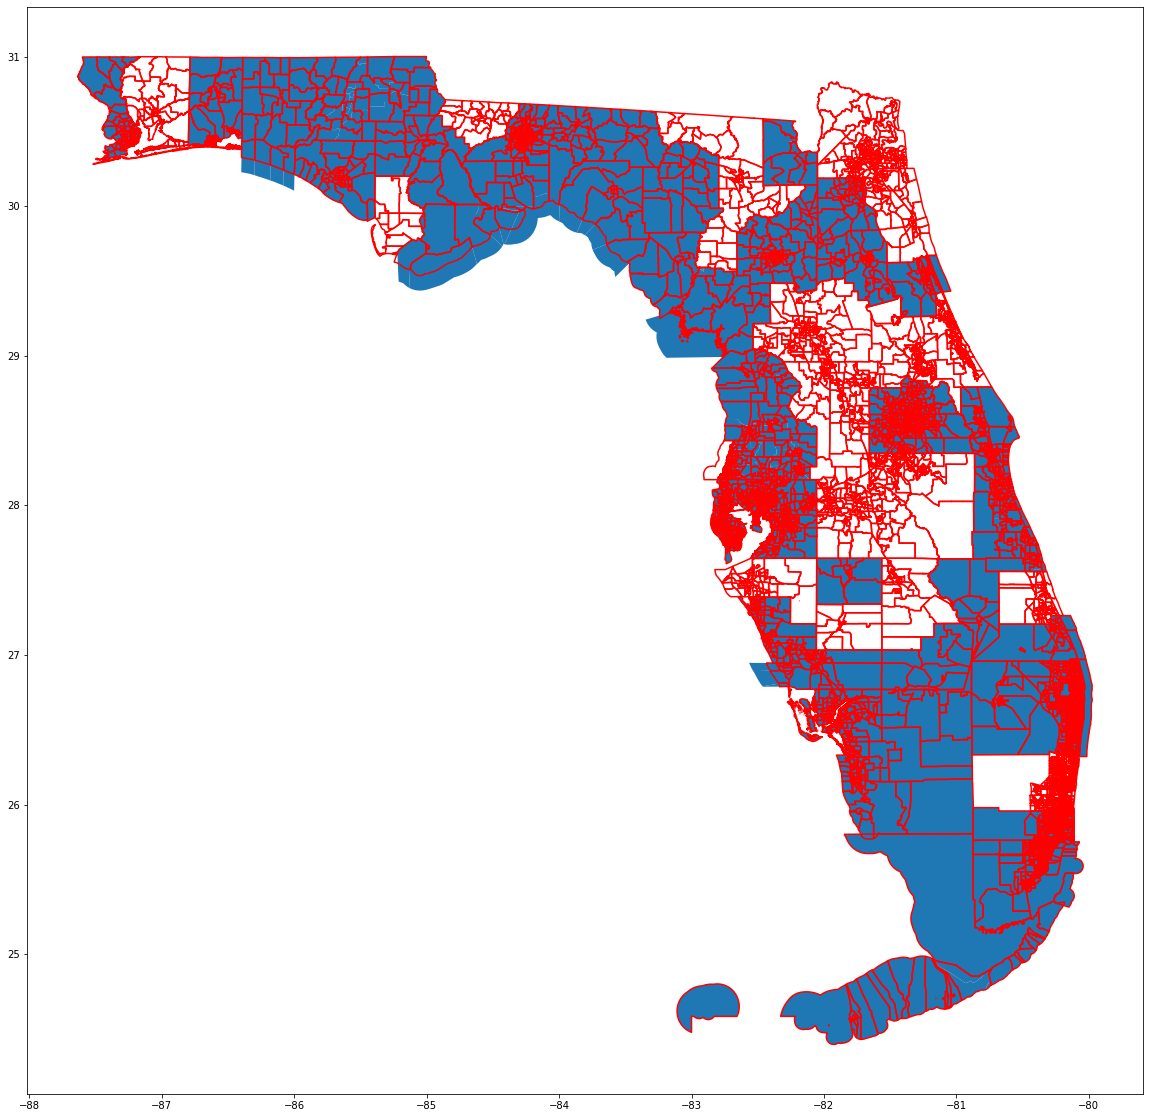

In [77]:
ax = final_source.plot(figsize=(20,20))
vest_fl_20.boundary.plot(ax=ax,color="red")

In [67]:
final_merge["final_merge"].value_counts()

both          4227
left_only     1783
right_only     118
Name: final_merge, dtype: int64

In [68]:
both = final_merge[final_merge["final_merge"]=="both"]
both.reset_index(inplace=True,drop=True)
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_fl_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_fl_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     2367
False    1860
dtype: int64


1) For CHA0008 difference in area is 4.068285502978285
2) For CHA0012 difference in area is 3.1548012475542486
3) For CHA0013 difference in area is 15.496427298559592
4) For CHA0015 difference in area is 2.188670952241219
5) For CHA0016 difference in area is 15.450681985396844
6) For CHA0018 difference in area is 4.030583316668158
7) For CHA0022 difference in area is 1.0295204188634741
8) For CHA0023 difference in area is 5.642552663246093
9) For CHA0024 difference in area is 1.7522450188473635
10) For CHA0026 difference in area is 1.3695841300510332
11) For CHA0027 difference in area is 1.192292404774898
12) For CHA0030 difference in area is 3.104017480762977
13) For CHA0031 difference in area is 65.03399842164247
14) For CHA0033 difference in area is 3.026530842244843
15) For CHA0034 difference in area is 1.0361982294473018
16) For CHA0036 difference in area is 1.6825442526559815
17) For CHA0038 difference in area is 1.3183056268230415
18) For CHA0041 difference in area is 1.62039039

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


24) For CHA0055 difference in area is 11.686825665501637
25) For CHA0060 difference in area is 1.2571085046124082
26) For CHA0067 difference in area is 9.23232981125708
27) For CHA0068 difference in area is 11.906369860348777
28) For CHA0078 difference in area is 2.7399855250075484
29) For FRA0002 difference in area is 18.33806746564596
30) For FRA0005 difference in area is 37.72742853431145
31) For FRA0006 difference in area is 15.68499856729874
32) For FRA0007 difference in area is 80.48762825590978
33) For FRA0008 difference in area is 15.40768797212351
34) For HER0004 difference in area is 5.212836071381345
35) For HER0010 difference in area is 3.216300353833505
36) For HER0017 difference in area is 8.13771546049019
37) For HER0018 difference in area is 1.344069540472874
38) For HER0036 difference in area is 11.469278444085875
39) For JAC0003 difference in area is 30.020260074469423
40) For JAC0004 difference in area is 27.82311400113033
41) For JAC0005 difference in area is 36.356

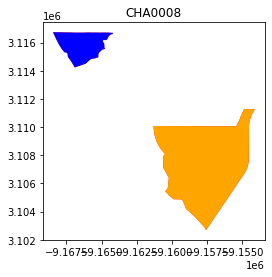

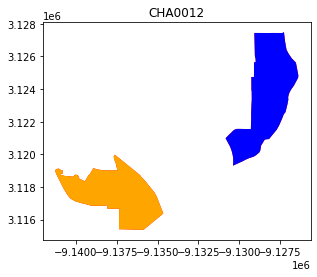

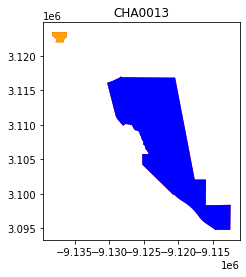

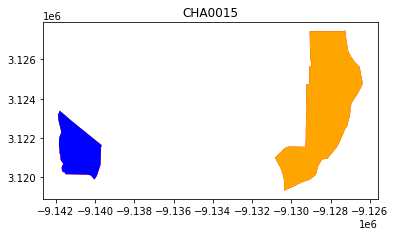

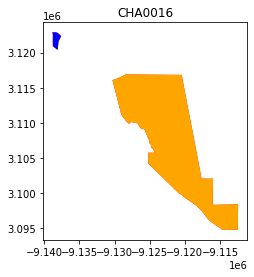

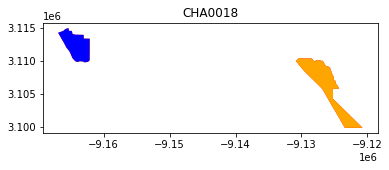

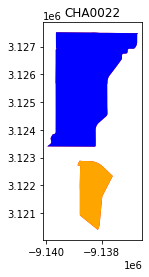

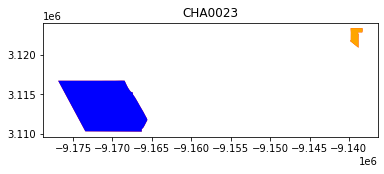

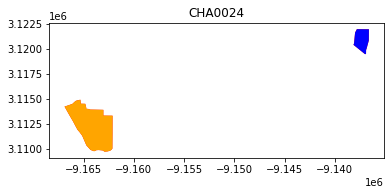

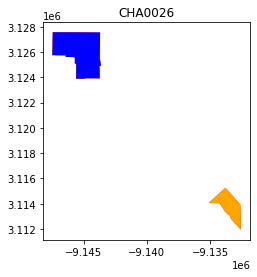

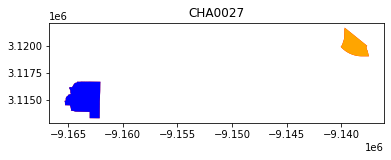

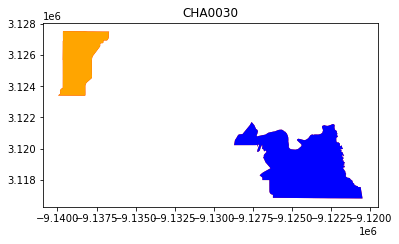

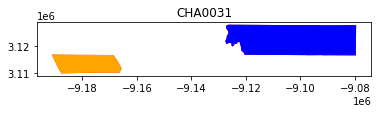

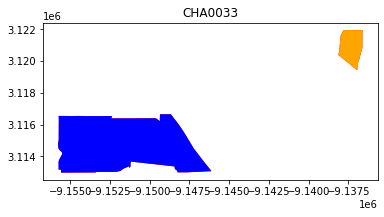

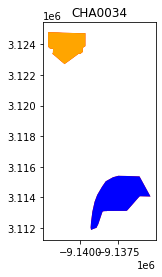

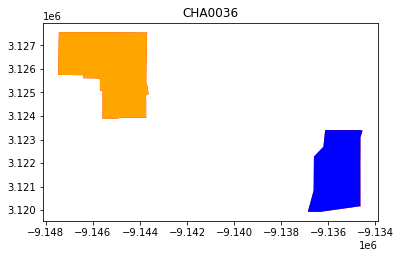

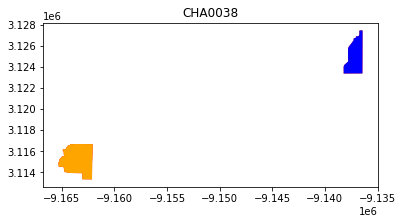

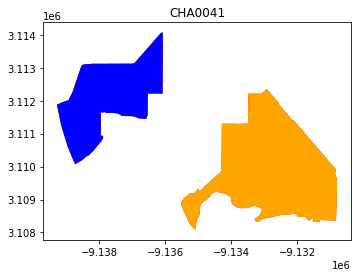

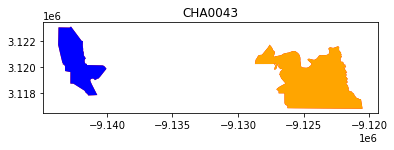

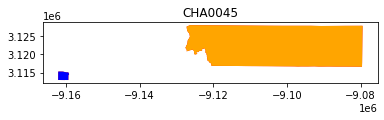

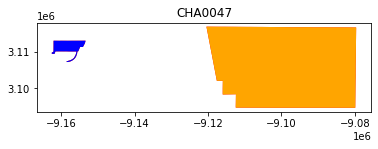

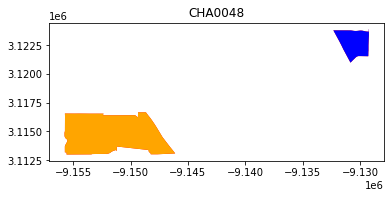

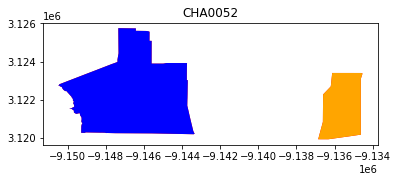

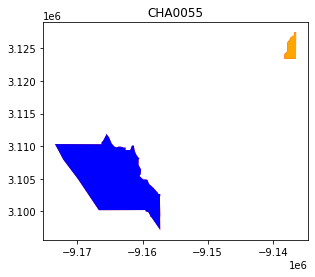

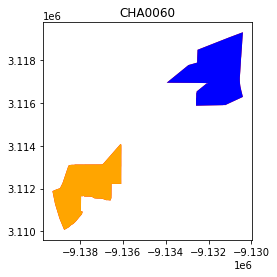

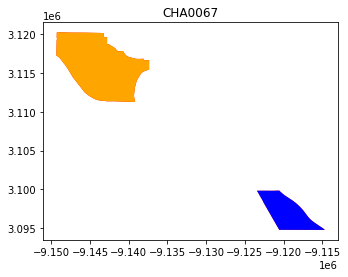

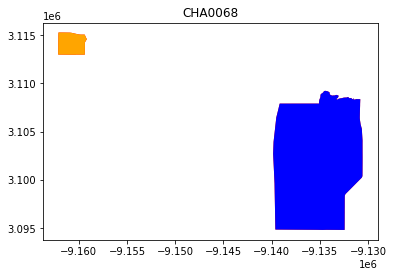

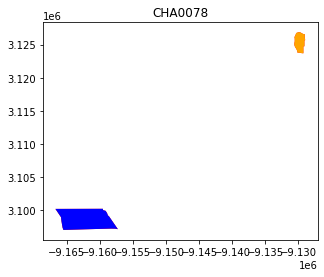

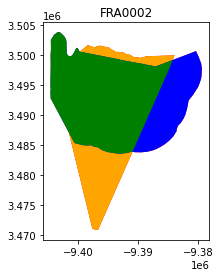

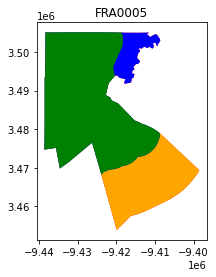

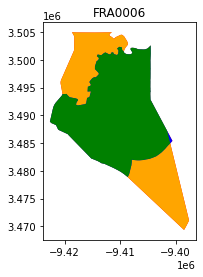

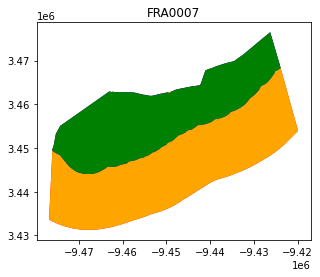

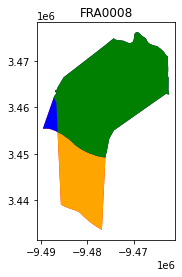

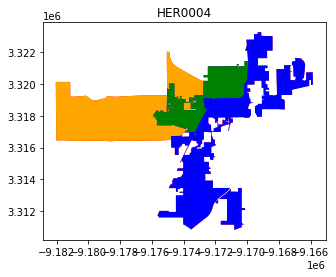

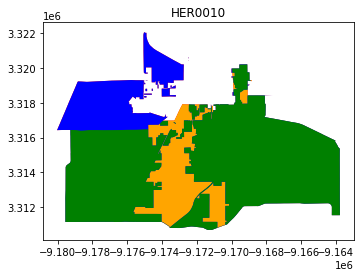

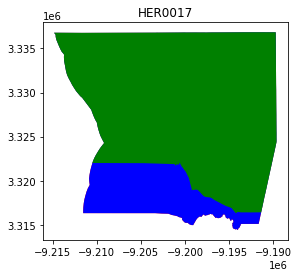

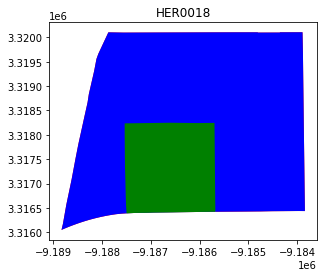

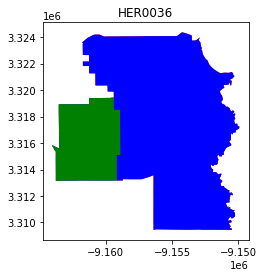

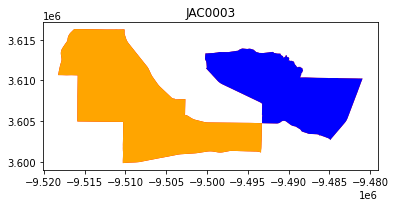

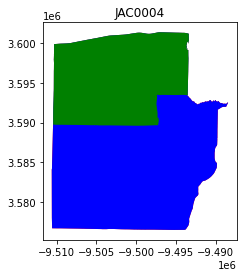

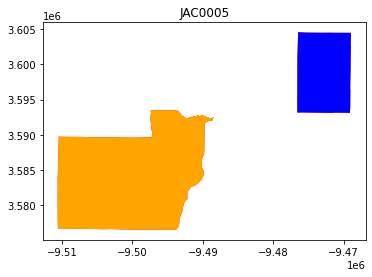

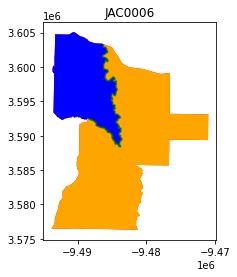

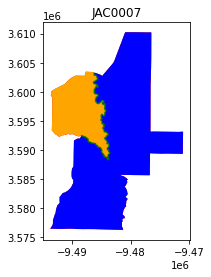

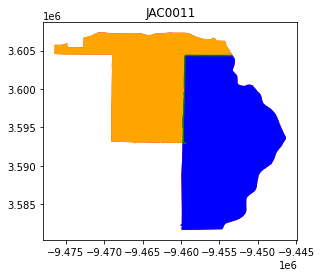

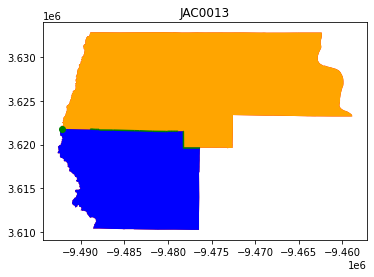

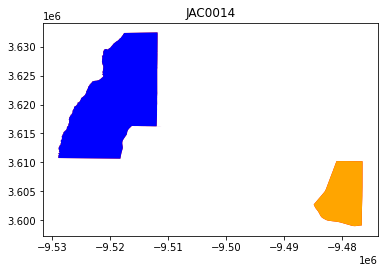

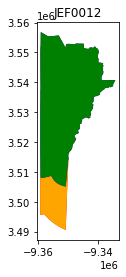

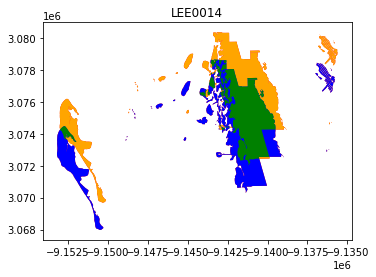

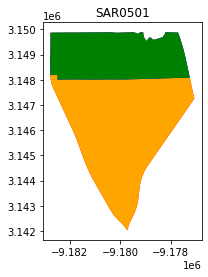

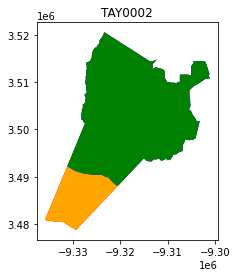

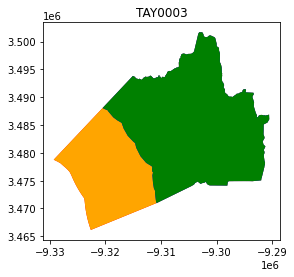

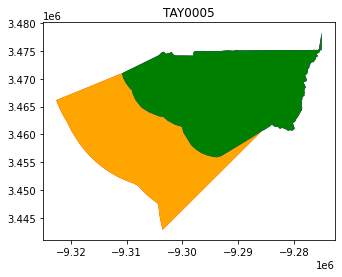

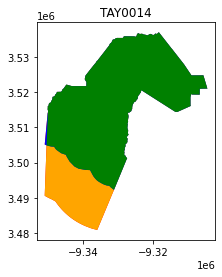

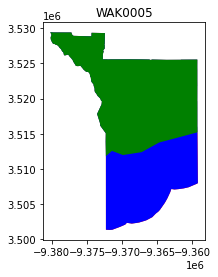

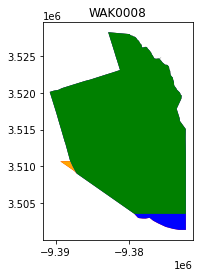

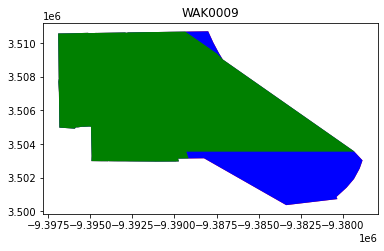

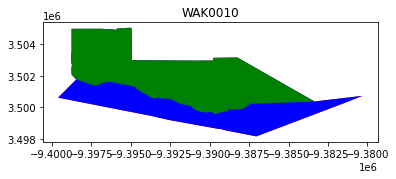

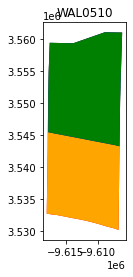

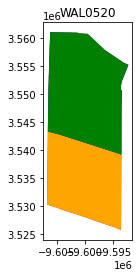

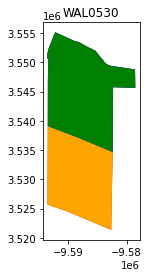

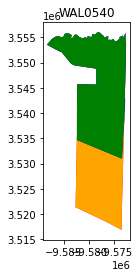

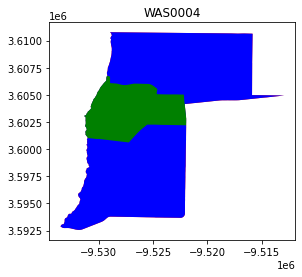

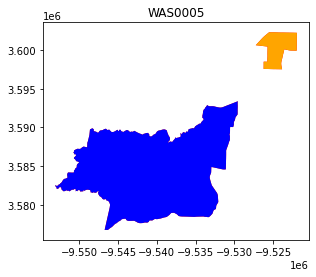

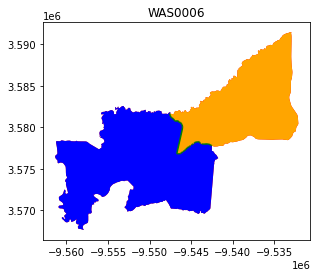

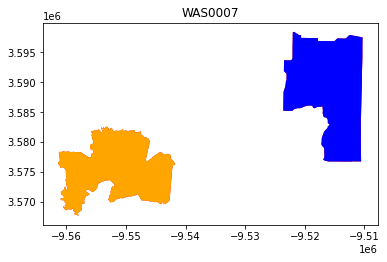

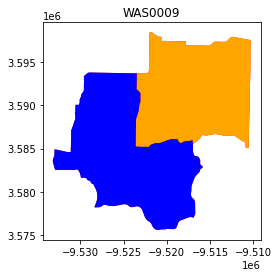

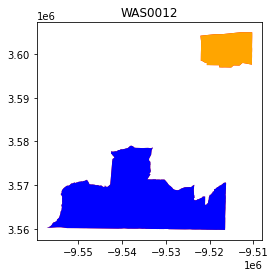

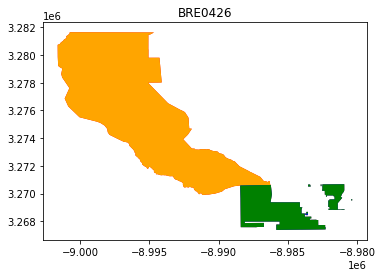

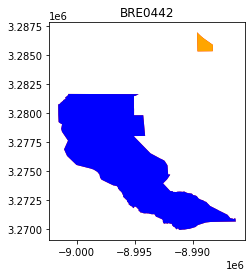

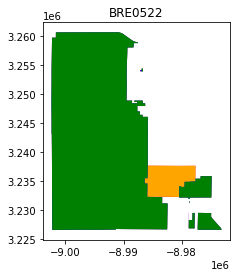

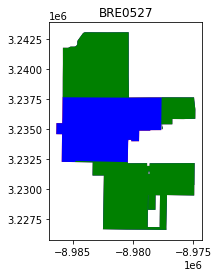

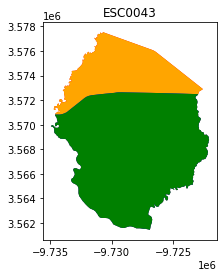

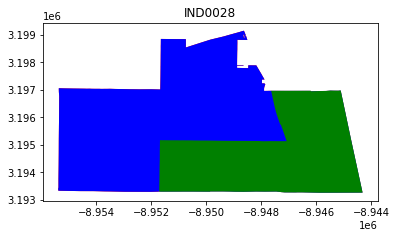

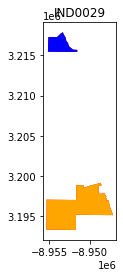

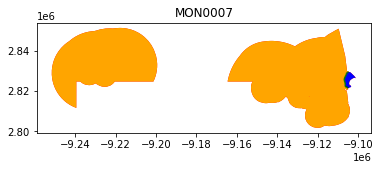

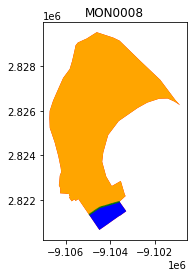

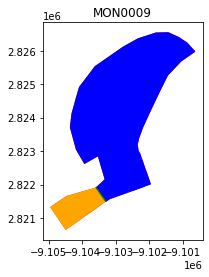

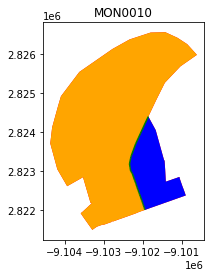

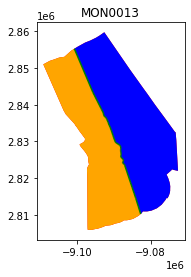

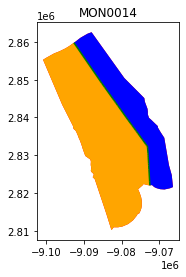

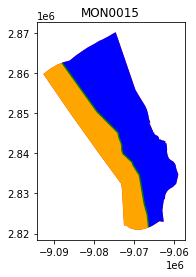

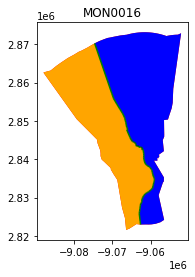

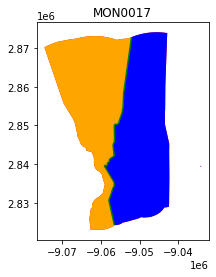

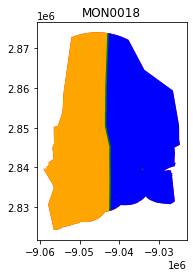

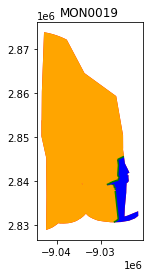

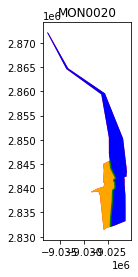

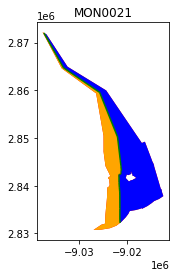

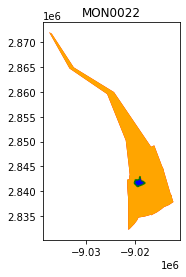

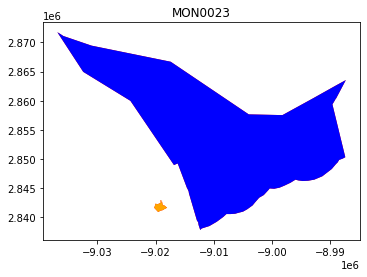

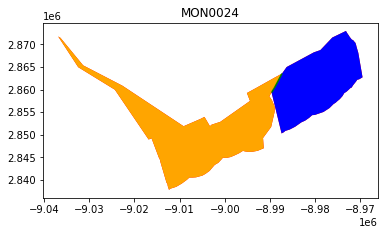

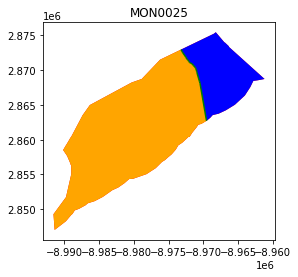

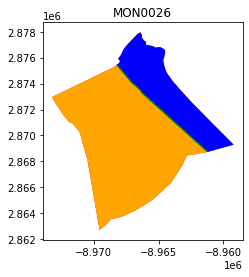

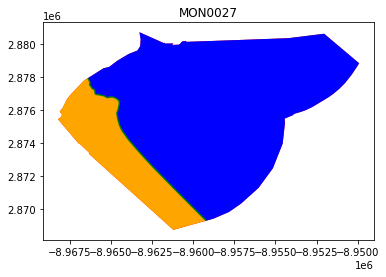

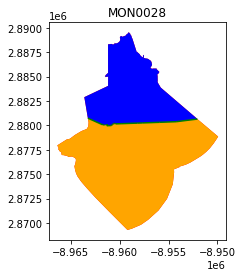

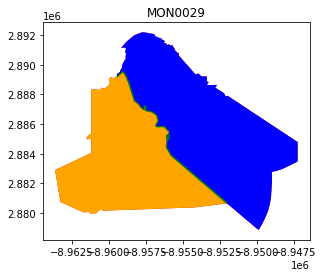

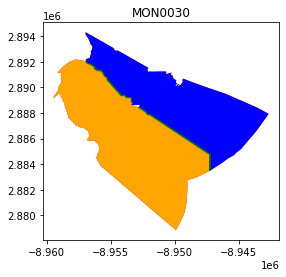

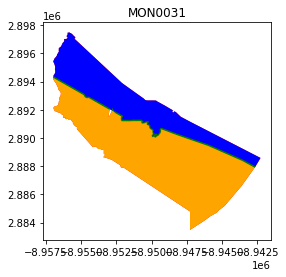

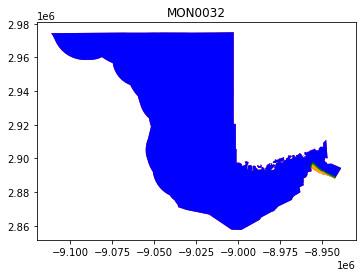

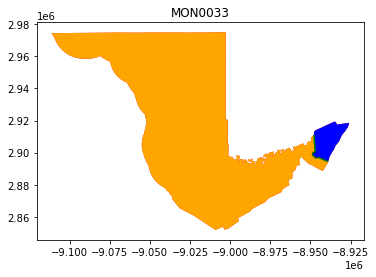

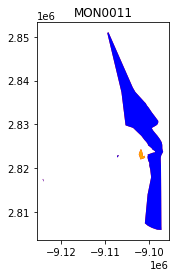

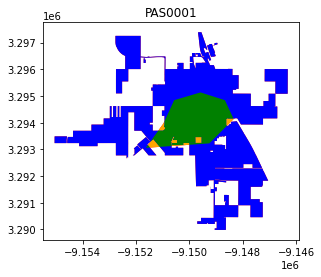

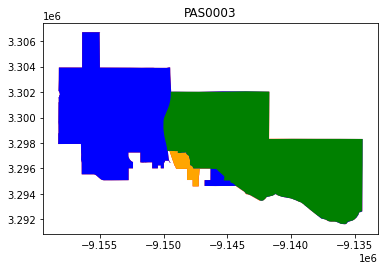

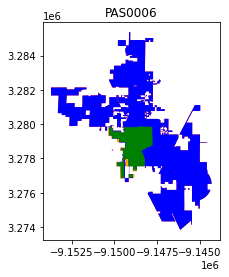

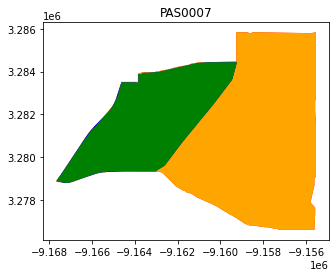

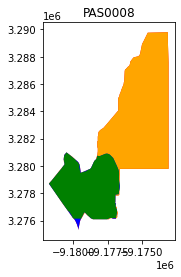

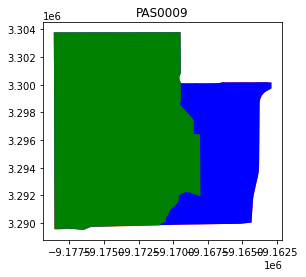

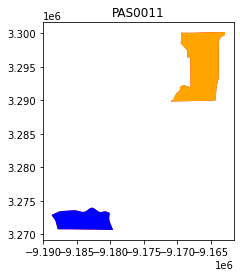

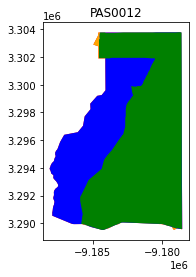

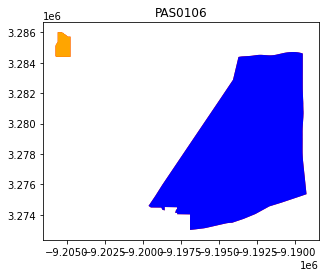

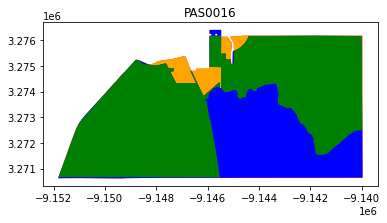

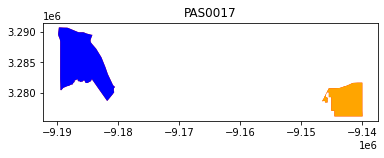

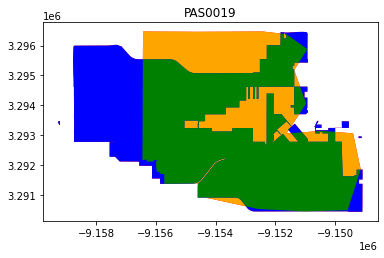

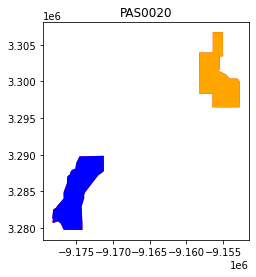

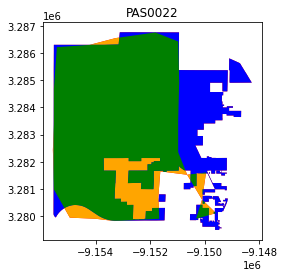

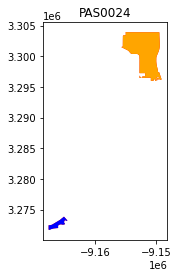

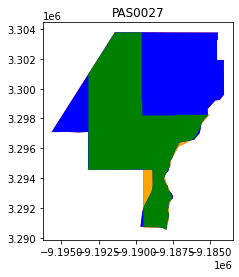

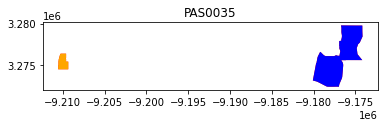

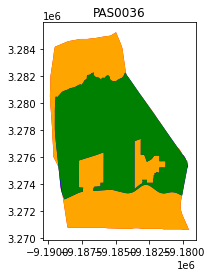

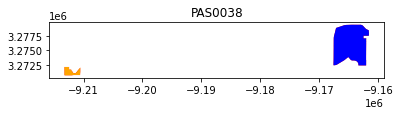

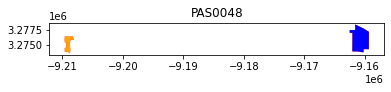

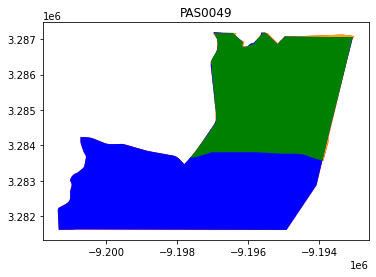

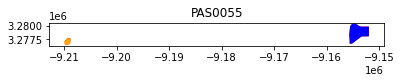

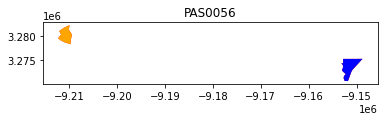

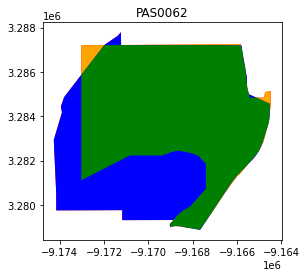

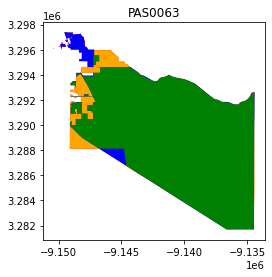

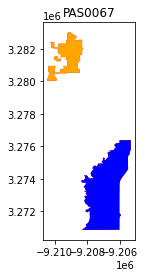

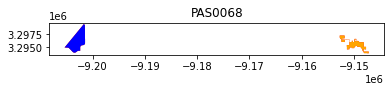

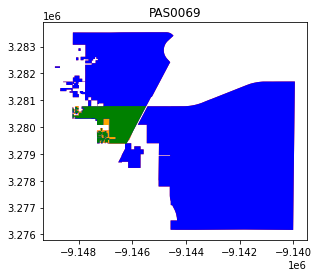

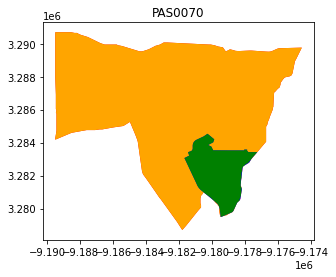

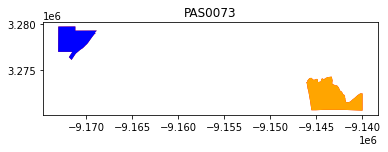

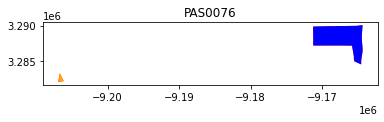

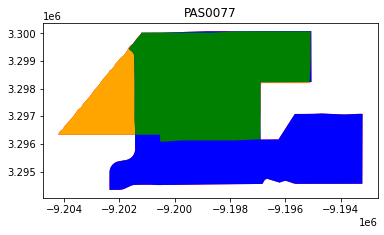

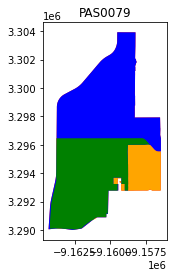

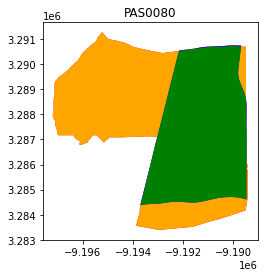

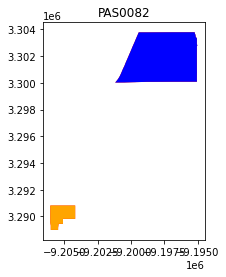

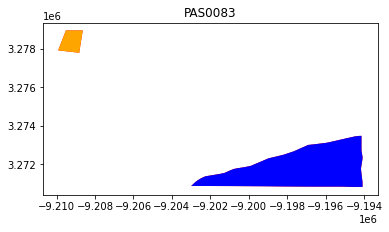

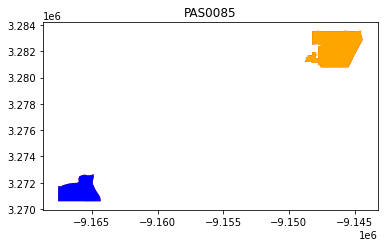

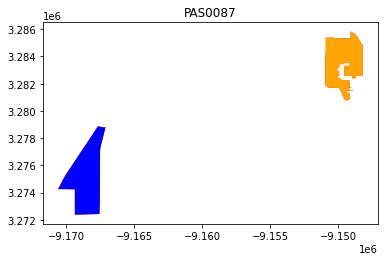

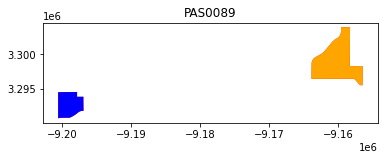

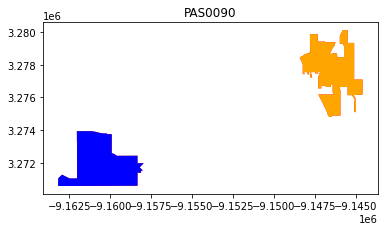

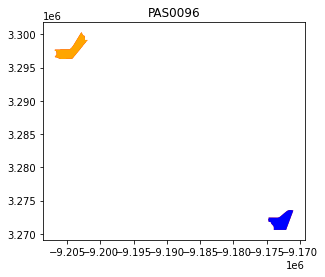

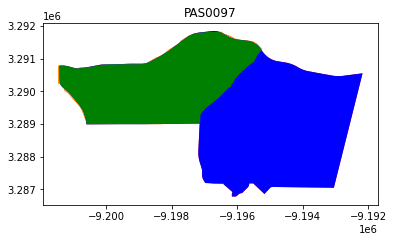

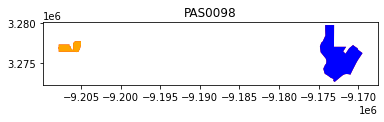

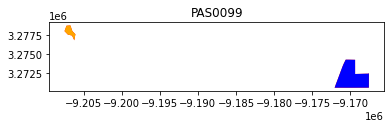

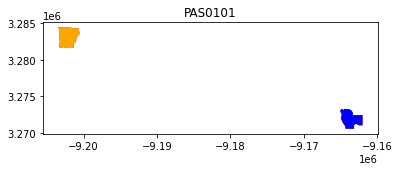

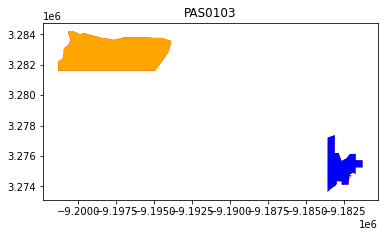

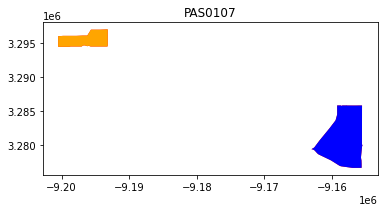

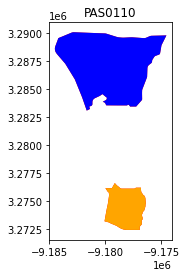

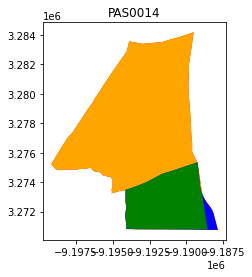

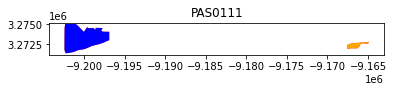

In [69]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))
    if (area > 1):
        count += 1
        name = source_geoms.at[i,"pct_std"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [70]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(4227, 1)
1173 precincts w/ a difference of 0 km^2
2796 precincts w/ a difference between 0 and .1 km^2
38 precincts w/ a difference between .1 and .5 km^2
26 precincts w/ a difference between .5 and 1 km^2
33 precincts w/ a difference between 1 and 2 km^2
40 precincts w/ a difference between 2 and 5 km^2
77 precincts w/ a difference greater than 5 km^2
